# Analysis of optogenetic activation experiments with short light pulses
## Comparison across experimental groups

*Experiment*: About 10 flies are placed in the free walking arena and full-field red light stimulation is delivered repeatedly for short periods.
We are looking for changes in the fly's walking velocities that are associated with the optogenetic activation.

In [53]:
from csv import reader
import numpy as np
from sys import path
from scipy import sparse as sps

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from matplotlib import gridspec

import pandas as pd

import os
from os.path import isfile, sep
from glob import glob

path.insert(1, '/Users/hannah/Dropbox/code/optogeneticsWalkingArena/')
from freeWalkingOptoPlotting import myAxisTheme

import seaborn as sns

%matplotlib inline

In [2]:
fps = 20

pre = -1
post = 3
timeAx = np.linspace(pre, post, (post-pre)*fps)

In [3]:
bins = np.linspace(pre, post, 2*(post-pre))
timeBins = np.digitize(timeAx, bins)/2.0 + pre*np.ones(len(timeAx))

In [4]:
bins2 = np.linspace(pre, post, 5*(post-pre))
timeBins2 = np.digitize(timeAx, bins2)/5.0 + pre*np.ones(len(timeAx))

### Load all averages from one stimulation group to data frame

In [5]:
basedDir = '/Volumes/jayaramanlab/Hannah/Projects/OptoFreeWalking/1_Data/RewardTest_Laura/fullFieldPulse/'
expDir = 'Gr43a-Gal4KI_x_10xChrimsonRWTB_female_RetWuerzburg/500ms/'
rootDir = basedDir + expDir + 'analysis'
expGroup = '_'.join(expDir.split('/')[0:-1])


datList = [filepath.split(sep)[-1] for filepath in glob(rootDir + sep + '*.csv')]

vt_datList = []
vr_datList = []
for fn in datList:
    if 'vTrans' in fn:
        vt_datList.append(fn)
    elif 'vRot' in fn:
        vr_datList.append(fn)
    else:
        pass

In [12]:
vt_df = pd.DataFrame(columns=['exprep', 'pulserep','starved','time','timebins','timebinsf','vt'])

for fi, currFile in enumerate(vt_datList):
    print(currFile)
    exprep = currFile.split('_')[6]
    
    # load file specifying data to be analysed
    datFile = open(rootDir+sep+currFile, 'r')
    csv_fileList = reader(datFile)

    for i, line in enumerate(csv_fileList):
        vtvals = np.asarray(line).astype('float')
        curr_df = pd.DataFrame(timeAx, columns=['time'])
        curr_df.insert(0, 'timebins',timeBins)
        curr_df.insert(0, 'timebinsf',timeBins2)
        curr_df.insert(1, 'vt',vtvals)
        curr_df.insert(2, 'pulserep',i+1)
        curr_df.insert(3, 'exprep',exprep)
        if '_20h' in currFile:
            curr_df.insert(3, 'starved','20h')
        elif '_12h' in currFile:
            curr_df.insert(3, 'starved','12h')
        elif '_0h' in currFile:
            curr_df.insert(3, 'starved','0h')
        vt_df = vt_df.append(curr_df, ignore_index = True)


Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_500ms_20h_rep4_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_500ms_0h_rep1_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_500ms_0h_rep3_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_500ms_20h_rep1_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_500ms_20h_rep2_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_500ms_20h_rep3_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_500ms_0h_rep2_vTrans_triggeredAverage.csv


In [16]:
vt_df

,exprep,pulserep,starved,time,timebins,timebinsf,vt
0,rep4,1.0,20h,-1.000000,-0.5,-0.8,3.504650
1,rep4,1.0,20h,-0.949367,-0.5,-0.8,3.115716
2,rep4,1.0,20h,-0.898734,-0.5,-0.8,3.510594
3,rep4,1.0,20h,-0.848101,-0.5,-0.8,3.894962
4,rep4,1.0,20h,-0.797468,-0.5,-0.8,3.516987
5,rep4,1.0,20h,-0.746835,-0.5,-0.6,3.160078
6,rep4,1.0,20h,-0.696203,-0.5,-0.6,3.261145
7,rep4,1.0,20h,-0.645570,-0.5,-0.6,3.227776
8,rep4,1.0,20h,-0.594937,-0.5,-0.6,3.177504
9,rep4,1.0,20h,-0.544304,-0.5,-0.4,3.522929


(0, 6)

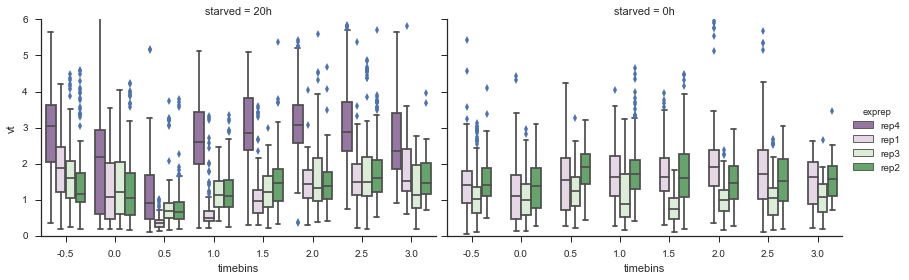

In [19]:
sns.set(style="ticks", color_codes=True)

sns.factorplot(data=vt_df, x="timebins", y="vt", hue="exprep", col="starved", palette="PRGn", kind='box', aspect=1.5)
plt.ylim(0, 6)

(0, 6)

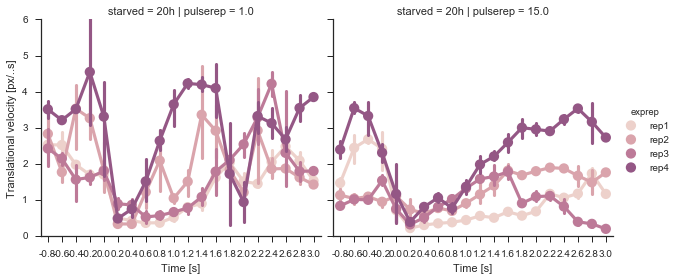

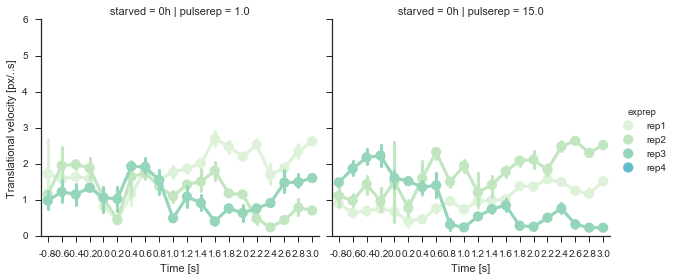

In [38]:
pulse_df = vt_df.query('(pulserep == 1 or pulserep == 15) and (starved == "20h" or starved == "12h")')
g = sns.factorplot(x="timebinsf", y="vt", hue="exprep", col="pulserep",row="starved", data=pulse_df,
                   hue_order=["rep1","rep2","rep3","rep4"],
                   capsize=.2, palette=sns.cubehelix_palette(6), size=4, aspect=1.1)
g.set_axis_labels("Time [s]", "Translational velocity [px/..s]")
plt.ylim(0, 6)

pulse_df = vt_df.query('(pulserep == 1 or pulserep == 15) and (starved == "0h")')
g = sns.factorplot(x="timebinsf", y="vt", hue="exprep", col="pulserep",row="starved", data=pulse_df,
                   hue_order=["rep1","rep2","rep3","rep4"],
                   capsize=.2, palette=sns.color_palette("GnBu"), size=4, aspect=1.1)
g.set_axis_labels("Time [s]", "Translational velocity [px/..s]")
plt.ylim(0, 6)

### Make data frame with just averages over all repeats and stimulation protocols

In [39]:
basedDir = '/Volumes/jayaramanlab/Hannah/Projects/OptoFreeWalking/1_Data/RewardTest_Laura/fullFieldPulse/'
expDir = 'Gr43a-Gal4KI_x_10xChrimsonRWTB_female_RetWuerzburg/'

vtav_df = pd.DataFrame(columns=['stim', 'exprep','starved','time','timebins','timebinsf','vt'])

for stim in ['500ms', '200ms']:

    rootDir = basedDir + expDir + stim + sep + 'analysis'
    expGroup = '_'.join(expDir.split('/')[0:-1])

    datList = [filepath.split(sep)[-1] for filepath in glob(rootDir + sep + '*.csv')]

    vt_datList = []
    vr_datList = []
    for fn in datList:
        if 'vTrans' in fn:
            vt_datList.append(fn)
        elif 'vRot' in fn:
            vr_datList.append(fn)
        else:
            pass
        
    for fi, currFile in enumerate(vt_datList):
        print(currFile)
        exprep = currFile.split('_')[6]

        # load file specifying data to be analysed
        datFile = open(rootDir+sep+currFile, 'r')
        csv_fileList = reader(datFile)

        vtvals = []

        for i, line in enumerate(csv_fileList):
            vtvals.append(line)

        avvals = np.nanmean(np.asarray(vtvals).astype('float'), axis=0)
        curr_df = pd.DataFrame(timeAx, columns=['time'])
        curr_df.insert(0, 'stim',stim)
        curr_df.insert(0, 'timebins',timeBins)
        curr_df.insert(0, 'timebinsf',timeBins2)
        curr_df.insert(1, 'vt',avvals)
        curr_df.insert(3, 'exprep',exprep)
        if '_20h' in currFile:
            curr_df.insert(3, 'starved','20h')
        elif '_12h' in currFile:
            curr_df.insert(3, 'starved','12h')
        elif '_0h' in currFile:
            curr_df.insert(3, 'starved','0h')
        vtav_df = vtav_df.append(curr_df, ignore_index = True)

Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_500ms_20h_rep4_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_500ms_0h_rep1_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_500ms_0h_rep3_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_500ms_20h_rep1_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_500ms_20h_rep2_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_500ms_20h_rep3_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_500ms_0h_rep2_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_200ms_20h_rep1_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_200ms_0h_rep2_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_200ms_20h_rep3_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_200ms_20h_rep2_vTrans_triggeredAverage.csv
Gr43a-Gal4KI_x_10xChrimsonRWTB_RetWuerzburg_200

In [40]:
vtav_df

,exprep,starved,stim,time,timebins,timebinsf,vt
0,rep4,20h,500ms,-1.000000,-0.5,-0.8,3.205760
1,rep4,20h,500ms,-0.949367,-0.5,-0.8,3.146157
2,rep4,20h,500ms,-0.898734,-0.5,-0.8,3.212774
3,rep4,20h,500ms,-0.848101,-0.5,-0.8,3.184143
4,rep4,20h,500ms,-0.797468,-0.5,-0.8,2.900950
5,rep4,20h,500ms,-0.746835,-0.5,-0.6,2.597248
6,rep4,20h,500ms,-0.696203,-0.5,-0.6,2.791010
7,rep4,20h,500ms,-0.645570,-0.5,-0.6,2.812591
8,rep4,20h,500ms,-0.594937,-0.5,-0.6,2.914590
9,rep4,20h,500ms,-0.544304,-0.5,-0.4,2.943259


(0, 4)

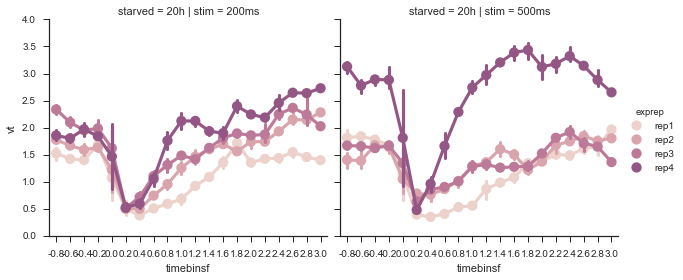

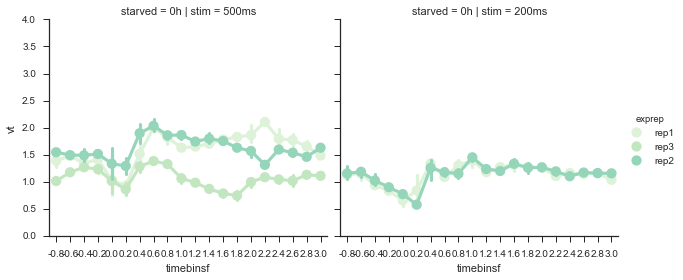

In [42]:
sns.set(style="ticks", color_codes=True)
starved_df = vtav_df.query('starved=="20h"')
g = sns.factorplot(x="timebinsf", y="vt", hue="exprep",row="starved",col="stim",
                   col_order=["200ms", "500ms"], hue_order=["rep1","rep2","rep3","rep4"],
                   data=starved_df,ci=95, capsize=.2, 
                   palette=sns.cubehelix_palette(6), size=4, aspect=1.1)
plt.ylim(0,4)

starved_df = vtav_df.query('starved=="0h"')
g = sns.factorplot(x="timebinsf", y="vt", hue="exprep",row="starved",col="stim",data=starved_df,ci=95, 
                   capsize=.2, palette=sns.color_palette("GnBu"), size=4, aspect=1.1)
plt.ylim(0,4)

(0, 4)

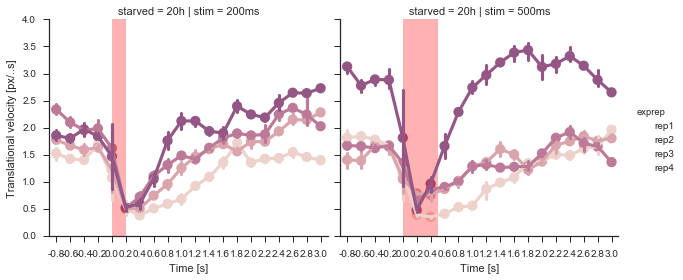

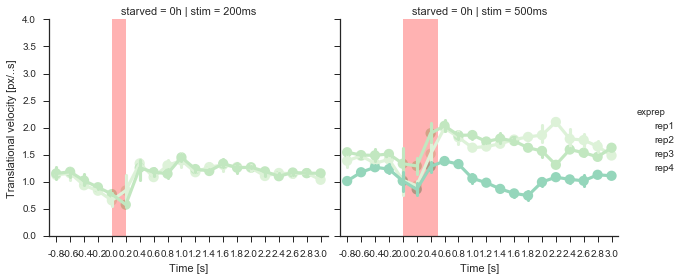

In [43]:
sns.set(style="ticks", color_codes=False)

starved_df = vtav_df.query('starved=="20h"')
g = sns.FacetGrid(data=starved_df, hue="exprep",row="starved",col="stim",
                  col_order=["200ms", "500ms"], hue_order=["rep1","rep2","rep3","rep4"],
                  palette=sns.cubehelix_palette(6),size=4, aspect=1.1)
g = (g.map(sns.pointplot,"timebinsf","vt",ci=95, capsize=.2).add_legend())

g.axes[0][0].add_patch(Rectangle((4, 0), 1, 4, facecolor='red', edgecolor='none', lw=1, alpha=0.3))
g.axes[0][1].add_patch(Rectangle((4, 0), 2.5, 4, facecolor='red', edgecolor='none', lw=1, alpha=0.3))
g.set_axis_labels("Time [s]", "Translational velocity [px/..s]")
plt.ylim(0,4)

starved_df = vtav_df.query('starved=="0h"')
g = sns.FacetGrid(data=starved_df, hue="exprep",row="starved",col="stim",
                  col_order=["200ms", "500ms"], hue_order=["rep1","rep2","rep3","rep4"],
                  palette=sns.color_palette("GnBu"),size=4, aspect=1.1)
g = (g.map(sns.pointplot,"timebinsf","vt",ci=95, capsize=.2).add_legend())

g.axes[0][0].add_patch(Rectangle((4, 0), 1, 4, facecolor='red', edgecolor='none', lw=1, alpha=0.3))
g.axes[0][1].add_patch(Rectangle((4, 0), 2.5, 4, facecolor='red', edgecolor='none', lw=1, alpha=0.3))
g.set_axis_labels("Time [s]", "Translational velocity [px/0.05s]")
plt.ylim(0,4)

Analysis folder already exists


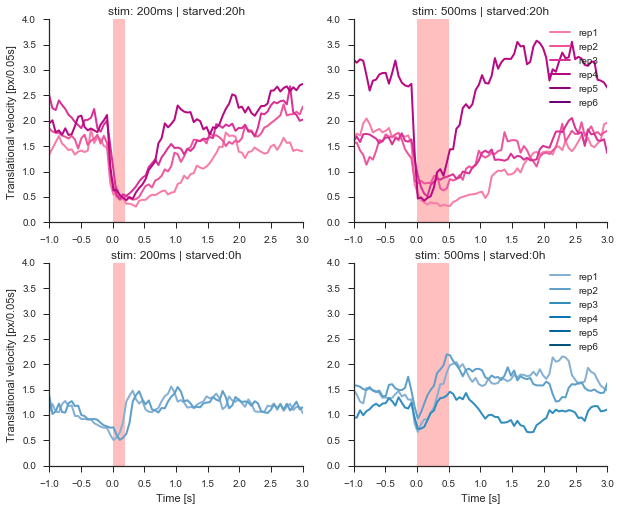

In [55]:
maxExpRep = 6
starveLevels = ['20h', '0h']
stimLevels = ['200ms', '500ms']
stimLevelRects = [0.2, 0.5]
repLevels = ['rep'+str(repn) for repn in range(1,maxExpRep+1)]

fig = plt.figure(figsize=(10,8))
for rowind, starved in enumerate(starveLevels):
    
    if starved == '0h': colMap = 'PuBu'
    else: colMap = 'RdPu'
    cNorm  = colors.Normalize(vmin=-5, vmax=maxExpRep)
    repCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=colMap)
    
    for colind, stim in enumerate(stimLevels):
        ax = fig.add_subplot(len(starveLevels),len(stimLevels),colind+(rowind*len(starveLevels))+1)
        for ind, rep in enumerate(repLevels):
            rep_df = vtav_df.query('exprep == "'+rep+'" and stim == "'+stim+'" and starved == "'+starved+'"')
            ax.plot(rep_df['time'].get_values(), rep_df['vt'].get_values(),
                    color=repCMap.to_rgba(ind), linewidth=2)
            ax.set_ylim(0,4)
        ax.set_title('stim: '+stim+' | starved:'+starved, fontsize=12)
        if rowind==1: ax.set_xlabel('Time [s]')
        if colind==0: ax.set_ylabel('Translational velocity [px/0.05s]')     
        if colind==1: ax.legend(repLevels, loc=1)
        myAxisTheme(ax)
        
        ax.add_patch(Rectangle((0, 0), stimLevelRects[colind], 4, facecolor='red', edgecolor='none', lw=1, alpha=0.25))

plotSaveDir = basedDir + expDir + sep + 'plots'
try:
    os.mkdir(plotSaveDir)
except OSError:
    print('Analysis folder already exists')
    
fig.savefig(plotSaveDir+sep+ expDir[:-2]+'_meanTriggeredAverages' + '.pdf', format = 'pdf')